# Front Matter: CASA0013: Foundations of Spatial Data Science

## Surviving the Pandemic: How Did COVID-19 Impact on Airbnbs in London

### Student ID: 21107925

# Reproducible Analysis

## 1. Reading Data

In [1]:
#importing packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

Data is to be directly imported from the [Inside Airbnb website](http://insideairbnb.com/get-the-data.html) for better replication. The 'mmmyy' style variable contains the data from each month's link. Inside Airbnb is providing about 108 cities' Airbnb listing data including London. It will take some time to load all from 10 links.

In [2]:
#importing inside airbnb data from each link - month/year
oct21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz'
sep21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-09-09/data/listings.csv.gz'
aug21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-08-07/data/listings.csv.gz'
jul21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-07-06/data/listings.csv.gz'
jun21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-06-07/data/listings.csv.gz'
apr21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-04-11/data/listings.csv.gz'
mar21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-03-05/data/listings.csv.gz'
feb21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-02-09/data/listings.csv.gz'
jan21 = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-01-11/data/listings.csv.gz'
dec20 = 'http://data.insideairbnb.com/united-kingdom/england/london/2020-12-16/data/listings.csv.gz'

In [3]:
links = [oct21, sep21, aug21, jul21, jun21, apr21, mar21, feb21, jan21, dec20]
# listing number, price, availability columns are picked to see the Airbnb's performance
cols = ['id', 'name', 'listing_url', 'price', 'latitude', 'longitude', 'host_id', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365']
dataset = [] # list of dataframes from each month -the latest month is on the first df
for link in links:
    df = pd.read_csv(link, compression='gzip', low_memory=False, usecols=cols)
    dataset.append(df)

In terms of geodata of London, the material used in this module is being reused. Borough level data is enough for the entire anlaysis here.

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

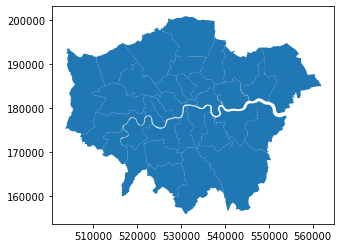

In [4]:
#importing borough geo-data from remote
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
boros.plot()

The map seems to have the whole picture of 33 boroughs. And here is another data file for London borough's dwelling and rent data below. Dwelling data is from [UK government data](https://www.gov.uk/government/statistical-data-sets/live-tables-on-dwelling-stock-including-vacants). It is written for the year 2019. Monthly rent datasets for borough were from [Homelet Rental Index](https://homelet.co.uk/homelet-rental-index), manually written down and woven as a csv file. `dwelling` is the number of dwellings in each borough in 2019. 'yyyyMMM' style variable means the monthly rent from the housing in boroughs, whose unit is GBP(£).

In [5]:
path = 'https://github.com/s-n-b-n/CASA0013_FSDSFinal/blob/7d447358b33522558350247d0fe76406e0ef3184/london_borough_dwellings_and_rent_2021.csv?raw=true'
rent_dwelling = pd.read_csv(path)
rent_dwelling.head()

,name,dwelling,2020DEC,2021JAN,2021FEB,2021MAR,2021APR,2021MAY,2021JUN,2021JUL,2021AUG,2021SEP,2021OCT
0,City of London,6506,1757,1795,1775,1809,1796,1815,1869,1975,2147,2153,2117
1,Barking and Dagenham,75829,1311,1288,1258,1289,1328,1322,1297,1334,1345,1335,1339
2,Barnet,152946,1543,1566,1562,1577,1567,1537,1547,1543,1571,1609,1627
3,Bexley,98391,1377,1380,1356,1362,1376,1378,1377,1383,1415,1395,1397
4,Brent,120448,1613,1563,1523,1537,1554,1610,1624,1647,1638,1647,1671


## 2. Merging and Cleaning Data
For the sake of spatial analysis of Airbnb listing, each listing should contain the geometry data. Spatial tagging of borough's geometry can also be achieved by spatial join(`.sjoin`) from geopandas. Here are merging Inside Airbnb data with borough geodata. 

In [6]:
# using geopandas, each listing acquires the geometry data
geodata = [] #this list has each month's airbnb listing and geometry data extracted from longitude and latitude of each listing
for data in dataset:
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude, crs='epsg:4326'))
    gdf = gdf.to_crs('epsg:27700')
    geodata.append(gdf)

In [7]:
# and spatial join with borough geographic data -> NAME: borough's name
geo_boro = [] 
for data in geodata:
    gdf_la = gpd.sjoin(data, boros, op='within', how='left')
    gdf_la.drop(columns=['index_right', 'NONLD_AREA', 'ONS_INNER'], inplace=True)
    gdf_la.drop(index=gdf_la[gdf_la.NAME.isna()].index, axis=1, inplace=True) # dropped the n/a value if there's in the NAME column
    geo_boro.append(gdf_la)
    
geo_boro[0].head()

,id,listing_url,name,host_id,latitude,longitude,price,has_availability,availability_30,availability_60,availability_90,availability_365,geometry,NAME,GSS_CODE,HECTARES
0,13913,https://www.airbnb.com/rooms/13913,Holiday London DB Room Let-on going,54730,51.56861,-0.11270,$65.00,t,5,34,64,339,POINT (530901.013 187213.787),Islington,E09000019,1485.664
1,15400,https://www.airbnb.com/rooms/15400,Bright Chelsea Apartment. Chelsea!,60302,51.48780,-0.16813,$75.00,t,0,0,0,2,POINT (527284.576 178129.679),Kensington and Chelsea,E09000020,1238.379
2,17402,https://www.airbnb.com/rooms/17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,51.52195,-0.14094,$307.00,t,11,27,52,320,POINT (529075.790 181974.865),Westminster,E09000033,2203.005
3,17506,https://www.airbnb.com/rooms/17506,Boutique Chelsea/Fulham Double bed 5-star ensuite,67915,51.47935,-0.19743,$150.00,t,29,59,89,364,POINT (525273.544 177139.513),Hammersmith and Fulham,E09000013,1715.409
4,24328,https://www.airbnb.com/rooms/24328,"Battersea bedroom & studio, parking, shared ga...",41759,51.47119,-0.16256,$200.00,t,0,0,12,273,POINT (527717.629 176292.280),Wandsworth,E09000032,3522.022


Here, we can see geometry data was hatched with the lon/lat from the listing and borough's name is put on each listing through spatial join under the column name `NAME`. N/A values in NAME column are to be dropped.  

In [8]:
for i in range(len(geo_boro)):
    print(dataset[i].shape[0] - geo_boro[i].shape[0])

12
8
11
19
12
15
10
3
6
14


These numbers of N/A values have been just dropped from each dataset. Since Airbnb does not provide exactly accurate location for public, there can be some discrepancies or errors of acquiring the exact location from the public data. 

Meanwhile, we still can see the dollar sign from every value in `price` column and it makes them 'object', not 'int' or 'float'. We need to clean it, too.

In [9]:
geo_boro[0].dtypes

id                     int64
listing_url           object
name                  object
host_id                int64
latitude             float64
longitude            float64
price                 object
has_availability      object
availability_30        int64
availability_60        int64
availability_90        int64
availability_365       int64
geometry            geometry
NAME                  object
GSS_CODE              object
HECTARES             float64
dtype: object

In [10]:
# cleaning dollor sign and changing the column into float type by using str.replace and regex
for i in range(len(geo_boro)):
    geo_boro[i]['price'] = geo_boro[i]['price'].str.replace('$','').str.replace(',','').astype('float')

/tmp/ipykernel_2832/1293193048.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  geo_boro[i]['price'] = geo_boro[i]['price'].str.replace('$','').str.replace(',','').astype('float')


In [11]:
geo_boro[0].dtypes

id                     int64
listing_url           object
name                  object
host_id                int64
latitude             float64
longitude            float64
price                float64
has_availability      object
availability_30        int64
availability_60        int64
availability_90        int64
availability_365       int64
geometry            geometry
NAME                  object
GSS_CODE              object
HECTARES             float64
dtype: object

`price` variable is now float64.

## 3. Getting Insights from Data (+ Subsetting Data)
Let's see the quick insight from the cleansed data first.

In [12]:
print(f'the whole number of listing in London of Oct, 2021 : {dataset[0].shape[0]}')
print(f'the whole number of listing in London of Dec, 2020 : {dataset[9].shape[0]}')
print(f'for the period, there was {(dataset[0].shape[0] - dataset[9].shape[0]) / dataset[9].shape[0] * 100} percent increase of listing')
print(f"availability change: {geo_boro[0]['availability_30'].mean() - geo_boro[9]['availability_30'].mean()}")
print(f"median price change: {geo_boro[0]['price'].median() - geo_boro[9]['price'].median()}")      

the whole number of listing in London of Oct, 2021 : 67903
the whole number of listing in London of Dec, 2020 : 77136
for the period, there was -11.969767683053309 percent increase of listing
availability change: -5.263229288896889
median price change: 5.0


Here is the data of each borough's listing count. Time's got reversed, so the earliest data comes first - i.e. `count0`: Dec 2020, `count9`: Oct 2021 

In [13]:
#borough airbnb listing counts - count0: Dec20, count9: Oct21
boro_counts = []
for i in range(len(geo_boro)):
    count = pd.DataFrame(geo_boro[-i-1].value_counts('NAME'), geo_boro[-i-1].value_counts('NAME').index.to_list()).reset_index()
    count.rename(columns={'index':'borough', 0:f'count{i}'}, inplace=True)
    boro_counts.append(count)
count_df = boro_counts[0]
for i in range(len(boro_counts)-1):
    count_df = pd.merge(count_df, boro_counts[i+1], how='left', on='borough')

count_df.head()

,borough,count0,count1,count2,count3,count4,count5,count6,count7,count8,count9
0,Westminster,8717,8736,8507,8447,8365,8150,8151,8237,7705,7229
1,Tower Hamlets,6870,6951,6890,6836,6633,6428,6314,6255,6051,5679
2,Hackney,5756,5767,5709,5677,5576,5457,5478,5475,5306,5178
3,Kensington and Chelsea,5297,5297,5285,5270,5250,5126,5156,5238,5049,4788
4,Camden,5261,5236,5179,5138,5119,5053,5110,5152,4914,4619


Now here will be adding the column referring to the percentage change between Oct 2021 and Dec 2020 (`diff_count`)

In [15]:
count_df['diff_count'] = ((count_df['count9'] - count_df['count0']) / count_df['count0']) * 100
count_df = count_df.sort_values(by='borough').reset_index().drop(columns=['index'])
count_df.sort_values(by='diff_count')

,borough,count0,count1,count2,count3,count4,count5,count6,count7,count8,count9,diff_count
6,City of London,471,487,441,409,418,413,414,403,352,356,-24.416136
3,Brent,2319,2355,2357,2354,2315,2159,2136,2101,2034,1908,-17.723157
29,Tower Hamlets,6870,6951,6890,6836,6633,6428,6314,6255,6051,5679,-17.336245
32,Westminster,8717,8736,8507,8447,8365,8150,8151,8237,7705,7229,-17.070093
9,Enfield,681,670,663,649,638,619,614,610,587,571,-16.152717
12,Hammersmith and Fulham,3593,3605,3497,3467,3416,3331,3310,3307,3172,3035,-15.530198
24,Newham,1876,1887,1842,1826,1783,1731,1711,1719,1652,1606,-14.392324
21,Lambeth,4363,4374,4324,4289,4192,4071,4059,4031,3873,3798,-12.949805
18,Islington,4497,4476,4501,4439,4314,4226,4214,4182,4034,3928,-12.652880
13,Haringey,2160,2170,2168,2144,2119,2043,2038,2041,1950,1890,-12.500000


And to see the availability change, `availability_30` `availability_60` `availability_90` `availability_365` variables will have its own seperate temporal dataframe. Each dataframe is to add another variable to show the difference between the latest and the earliest. `avaliability_x` means the availability of the listing x days in the future as determined by the calendar. 

In [16]:
avail30_means = []
for i in range(len(geo_boro)):
    av_mean = geo_boro[-i-1].groupby('NAME')['availability_30'].mean().reset_index()
    av_mean.rename(columns={'NAME': 'borough', 'availability_30': f'av30mean{i}'}, inplace=True)
    avail30_means.append(av_mean)

avail30_df = avail30_means[0]
for i in range(len(avail30_means)-1):
    avail30_df = pd.merge(avail30_df, avail30_means[i+1], how='left', on='borough')

avail30_df['diff_avail30'] = avail30_df['av30mean9'] - avail30_df['av30mean0']

avail30_df.sort_values(by=['diff_avail30'])

,borough,av30mean0,av30mean1,av30mean2,av30mean3,av30mean4,av30mean5,av30mean6,av30mean7,av30mean8,av30mean9,diff_avail30
6,City of London,16.040340,14.252567,15.335601,15.278729,12.839713,11.171913,12.002415,10.704715,7.860795,7.595506,-8.444834
32,Westminster,13.926121,14.383356,14.288586,13.810110,12.824029,10.922454,12.188320,11.900206,8.431538,7.116890,-6.809231
19,Kensington and Chelsea,13.437606,13.568813,13.542100,13.127324,11.777143,10.134218,11.394686,11.526537,8.106556,6.910819,-6.526787
5,Camden,11.753469,12.140756,11.681985,11.400934,10.203165,8.856323,9.999413,9.717003,6.760887,5.620697,-6.132772
12,Hammersmith and Fulham,10.572780,11.075728,10.958250,10.501010,9.159251,7.702492,8.483384,8.368310,5.709962,4.804613,-5.768168
29,Tower Hamlets,10.396507,10.790246,10.406531,10.210796,9.327001,8.265713,8.989230,8.602878,6.026607,4.881845,-5.514661
24,Newham,13.150320,13.648649,12.996743,13.146221,12.249579,10.642403,11.572180,11.501454,8.809322,7.788294,-5.362026
3,Brent,12.345839,12.641189,12.548154,12.109176,11.146004,9.909680,10.568352,9.789624,7.934612,7.109539,-5.236300
18,Islington,8.327107,8.513181,8.260609,8.107682,7.078350,5.842641,6.517323,6.319225,3.736490,3.210031,-5.117076
1,Barnet,14.307130,14.889831,14.679487,14.185185,13.089908,11.649407,12.681168,12.448552,9.490146,9.234043,-5.073087


In [17]:
avail60_means = []
for i in range(len(geo_boro)):
    av_mean = geo_boro[-i-1].groupby('NAME')['availability_60'].mean().reset_index()
    av_mean.rename(columns={'NAME': 'borough', 'availability_60': f'av60mean{i}'}, inplace=True)
    avail60_means.append(av_mean)

avail60_df = avail60_means[0]
for i in range(len(avail60_means)-1):
    avail60_df = pd.merge(avail60_df, avail60_means[i+1], how='left', on='borough')

avail60_df['diff_avail60'] = avail60_df['av60mean9'] - avail60_df['av60mean0']

avail60_df.sort_values(by=['diff_avail60']).head()

,borough,av60mean0,av60mean1,av60mean2,av60mean3,av60mean4,av60mean5,av60mean6,av60mean7,av60mean8,av60mean9,diff_avail60
6,City of London,33.579618,30.521561,30.190476,33.435208,28.263158,23.237288,26.379227,23.652605,20.724432,20.081461,-13.498157
32,Westminster,30.102099,30.256410,30.202539,29.267787,27.573700,23.769448,26.911422,26.063494,20.632706,17.381381,-12.720719
5,Camden,25.519483,26.095684,25.240008,24.611911,22.525103,19.994261,22.481605,21.116266,16.772283,14.003031,-11.516452
19,Kensington and Chelsea,28.833113,28.727393,28.720530,27.693548,25.415429,22.644947,25.589216,24.990454,20.559121,17.681704,-11.151409
12,Hammersmith and Fulham,23.156972,23.652150,23.091221,22.177964,19.942623,17.386971,19.224169,18.438464,14.707440,12.719934,-10.437038


In [18]:
avail90_means = []
for i in range(len(geo_boro)):
    av_mean = geo_boro[-i-1].groupby('NAME')['availability_90'].mean().reset_index()
    av_mean.rename(columns={'NAME': 'borough', 'availability_90': f'av90mean{i}'}, inplace=True)
    avail90_means.append(av_mean)

avail90_df = avail90_means[0]
for i in range(len(avail90_means)-1):
    avail90_df = pd.merge(avail90_df, avail90_means[i+1], how='left', on='borough')

avail90_df['diff_avail90'] = avail90_df['av90mean9'] - avail90_df['av90mean0']

avail90_df.sort_values(by=['diff_avail90']).head()

,borough,av90mean0,av90mean1,av90mean2,av90mean3,av90mean4,av90mean5,av90mean6,av90mean7,av90mean8,av90mean9,diff_avail90
32,Westminster,46.546748,46.338599,46.287293,44.990884,42.496832,37.621350,42.177524,41.138521,34.229202,28.751695,-17.795053
6,City of London,49.740977,46.767967,45.163265,51.430318,41.811005,36.464891,40.768116,37.148883,34.644886,33.308989,-16.431988
5,Camden,39.795286,40.535523,39.267233,38.454457,35.556163,32.396200,35.309002,33.704775,28.079976,23.752977,-16.042309
19,Kensington and Chelsea,44.669247,44.185199,44.012488,42.694497,39.501714,36.142216,40.011249,39.316342,34.067736,29.552632,-15.116615
12,Hammersmith and Fulham,36.060952,36.435506,35.509008,34.141333,30.991803,28.071750,30.671299,29.649834,25.012295,21.809885,-14.251067


In [19]:
avail365_means = []
for i in range(len(geo_boro)):
    av_mean = geo_boro[-i-1].groupby('NAME')['availability_365'].mean().reset_index()
    av_mean.rename(columns={'NAME': 'borough', 'availability_365': f'av365mean{i}'}, inplace=True)
    avail365_means.append(av_mean)

avail365_df = avail365_means[0]
for i in range(len(avail365_means)-1):
    avail365_df = pd.merge(avail365_df, avail365_means[i+1], how='left', on='borough')

avail365_df['diff_avail365'] = avail365_df['av365mean9'] - avail365_df['av365mean0']

avail365_df.sort_values(by=['diff_avail365']).head()

,borough,av365mean0,av365mean1,av365mean2,av365mean3,av365mean4,av365mean5,av365mean6,av365mean7,av365mean8,av365mean9,diff_avail365
5,Camden,133.076221,133.065508,128.833172,129.519074,124.861301,113.984168,124.719178,125.107337,114.363248,101.885257,-31.190965
32,Westminster,153.215671,149.295444,148.035383,147.827986,144.713927,134.475337,149.164642,150.435960,139.226087,123.947711,-29.267960
19,Kensington and Chelsea,149.911837,146.009628,147.475307,147.997913,140.905714,128.754975,141.362684,142.467163,132.008318,120.801170,-29.110667
25,Redbridge,177.370262,179.688761,168.062319,170.269231,164.186364,154.688693,166.274742,166.982634,158.012140,151.541463,-25.828799
18,Islington,91.795197,91.427614,90.006665,89.495607,81.486324,73.005206,80.943284,80.491870,71.698066,66.567210,-25.227987


The same operation is applied to median price of every borough's listing. Median price is employed here as average is reflecting too much weight from the expensive listing in certain areas. Variable name is set as `price_med` and difference between two timing is also to be calculated.

In [20]:
price_medians = []
for i in range(len(geo_boro)):
    price_median = geo_boro[-i-1].groupby('NAME')['price'].median().reset_index()
    price_median.rename(columns={'NAME': 'borough', 'price': f'price_med{i}'}, inplace=True)
    price_medians.append(price_median)

price_df = price_medians[0]
for i in range(len(price_medians)-1):
    price_df = pd.merge(price_df, price_medians[i+1], how='left', on='borough')

price_df['diff_price'] = (price_df['price_med9'] - price_df['price_med0']) / price_df['price_med0'] * 100   

price_df.sort_values(by=['diff_price'], ascending=False)

,borough,price_med0,price_med1,price_med2,price_med3,price_med4,price_med5,price_med6,price_med7,price_med8,price_med9,diff_price
6,City of London,123.0,120.0,119.0,105.0,110.0,121.0,125.0,125.0,139.5,145.0,17.886179
19,Kensington and Chelsea,125.0,120.0,120.0,120.0,122.0,130.0,130.0,130.0,140.0,146.5,17.200000
20,Kingston upon Thames,55.0,55.0,55.0,54.0,55.0,55.0,57.0,58.0,60.0,64.0,16.363636
23,Merton,65.0,65.0,65.0,65.0,65.0,70.0,71.5,70.0,70.0,75.0,15.384615
0,Barking and Dagenham,43.0,45.0,45.0,44.0,43.0,45.0,43.5,43.5,47.0,49.5,15.116279
10,Greenwich,60.0,60.0,60.0,60.0,60.5,65.0,65.0,65.0,69.0,69.0,15.000000
24,Newham,51.0,50.0,52.0,51.0,50.0,52.0,52.0,54.0,56.0,58.0,13.725490
32,Westminster,120.0,110.0,110.0,111.0,119.0,124.0,127.0,125.0,130.0,136.0,13.333333
7,Croydon,40.0,40.0,40.0,40.0,40.0,41.5,43.0,45.0,45.0,45.0,12.500000
2,Bexley,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,45.0,45.0,12.500000


Using borough's dwelling and monthly rent data, which is stored as `rent_dwelling` here, we can see the density (listing per dwelling) of borough and check how much change had occurred in terms of rent during the selected period. These two factors will be added as variables, as well. 

In [21]:
rent_dwelling['diff_rent'] = (rent_dwelling['2021OCT'] - rent_dwelling['2020DEC']) / rent_dwelling['2020DEC'] * 100
rent_dwelling = rent_dwelling.sort_values(by=['name']).reset_index().drop(columns=['index'])
rent_dwelling.sort_values(by=['diff_rent'], ascending=False)

,name,dwelling,2020DEC,2021JAN,2021FEB,2021MAR,2021APR,2021MAY,2021JUN,2021JUL,2021AUG,2021SEP,2021OCT,diff_rent
29,Tower Hamlets,121539,1517,1513,1506,1551,1584,1611,1642,1649,1750,1857,1879,23.862887
32,Westminster,125312,2232,2273,2251,2228,2171,2183,2349,2491,2593,2646,2761,23.700717
21,Lambeth,141507,2014,1999,2065,2055,2048,2053,2083,2124,2239,2380,2435,20.903674
5,Camden,105598,1757,1795,1775,1809,1796,1815,1869,1975,2147,2153,2117,20.489471
6,City of London,6506,1757,1795,1775,1809,1796,1815,1869,1975,2147,2153,2117,20.489471
28,Sutton,83553,1360,1334,1338,1337,1381,1425,1435,1442,1455,1501,1584,16.470588
23,Merton,84570,1360,1334,1338,1337,1381,1425,1435,1442,1455,1501,1584,16.470588
20,Kingston upon Thames,67642,1360,1334,1338,1337,1381,1425,1435,1442,1455,1501,1584,16.470588
22,Lewisham,128115,1508,1555,1549,1588,1563,1548,1569,1614,1737,1769,1745,15.716180
27,Southwark,136178,1508,1555,1549,1588,1563,1548,1569,1614,1737,1769,1745,15.716180


All of the variables added and subsetted will be collected and stored in one dataframe for the sake of organised anlaysis.

In [24]:
target_df = count_df[['borough', 'count9', 'diff_count']]
target_df['diff_avail30'] = avail30_df['diff_avail30']
target_df['diff_avail60'] = avail60_df['diff_avail60']
target_df['diff_avail90'] = avail90_df['diff_avail90']
target_df['diff_avail365'] = avail365_df['diff_avail365']
target_df['diff_price'] = price_df['diff_price']
target_df['diff_rent'] = rent_dwelling['diff_rent']
target_df['dwelling'] = rent_dwelling['dwelling']
target_df['per_dwell'] = target_df['count9'] / target_df['dwelling'] * 100

target_df.sort_values(by='per_dwell')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,borough,count9,diff_count,diff_avail30,diff_avail60,diff_avail90,diff_avail365,diff_price,diff_rent,dwelling,per_dwell
15,Havering,255,-3.409091,-2.255036,-4.178788,-6.706373,-13.306907,0.000000,2.135774,102459,0.248880
2,Bexley,272,-1.805054,-4.399222,-8.116200,-10.973057,-10.579767,12.500000,1.452433,98391,0.276448
28,Sutton,275,-6.779661,-3.484807,-5.868166,-7.653190,-8.599199,11.111111,16.470588,83553,0.329132
4,Bromley,543,-7.653061,-4.112489,-9.196443,-13.809336,-20.653334,10.000000,1.712329,139684,0.388735
9,Enfield,571,-16.152717,-4.659080,-8.348805,-12.088795,-20.615277,0.000000,3.187251,126255,0.452259
14,Harrow,430,-5.908096,-5.032416,-8.125775,-10.738146,-13.574749,8.695652,-2.425107,91909,0.467854
0,Barking and Dagenham,390,-5.109489,-4.105222,-6.458113,-8.658450,-5.396182,15.116279,2.135774,75829,0.514315
16,Hillingdon,575,-7.258065,-3.704909,-6.138682,-7.780813,-0.831360,11.111111,-2.425107,110734,0.519262
25,Redbridge,615,-10.349854,-4.507426,-7.498109,-11.042191,-25.828799,11.111111,6.698951,104688,0.587460
7,Croydon,1055,-5.550582,-4.200961,-7.695963,-10.975949,-10.913626,12.500000,9.437387,161060,0.655035


So, here is the final version of dataframe to implement the final analysis and visualisation.

In [23]:
#count9: listing count in Oct 2021, diff_count: percent, diff_availxx: day, diff_price: percent, diff_rent: percent, dwelling: unit
target_gdf = pd.merge(target_df, boros, how='left', left_on='borough', right_on='NAME').drop(columns=['NONLD_AREA', 'ONS_INNER', 'NAME'])
target_gdf = target_gdf.set_geometry('geometry')
target_gdf.head()

,borough,count9,diff_count,diff_avail30,diff_avail60,diff_avail90,diff_avail365,diff_price,diff_rent,dwelling,per_dwell,GSS_CODE,HECTARES,geometry
0,Barking and Dagenham,390,-5.109489,-4.105222,-6.458113,-8.658450,-5.396182,15.116279,2.135774,75829,0.514315,E09000002,3779.934,"MULTIPOLYGON (((543905.400 183199.100, 543905...."
1,Barnet,1504,-8.348568,-5.073087,-8.974755,-12.563883,-20.789019,10.909091,5.443940,152946,0.983354,E09000003,8674.837,"MULTIPOLYGON (((524579.900 198355.200, 524594...."
2,Bexley,272,-1.805054,-4.399222,-8.116200,-10.973057,-10.579767,12.500000,1.452433,98391,0.276448,E09000004,6428.649,"MULTIPOLYGON (((547226.200 181299.300, 547320...."
3,Brent,1908,-17.723157,-5.236300,-9.158535,-12.190100,-14.321732,6.153846,3.595784,120448,1.584086,E09000005,4323.270,"MULTIPOLYGON (((525201.000 182512.600, 525181...."
4,Bromley,543,-7.653061,-4.112489,-9.196443,-13.809336,-20.653334,10.000000,1.712329,139684,0.388735,E09000006,15013.487,"MULTIPOLYGON (((540373.600 157530.400, 540361...."


## 4. Visualisation
Before draw#font selection
import matplotlib
loc = matplotlib.get_cachedir()
!ls {loc}
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
print(fonts)ing the map and visuals, we're selecting the neater font for better pictures.

In [26]:
#font selection
import matplotlib
loc = matplotlib.get_cachedir()
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

Here comes the visualisation of Airbnb Listing Count Change per Borough. 

Text(0.0, 1.0, 'Airbnb Listing Change per Borough(%, Dec20-Oct21)')

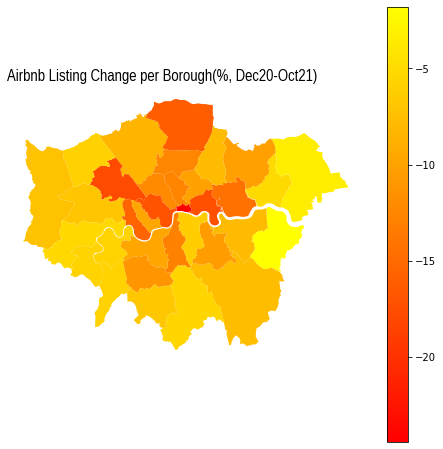

In [28]:
f, ax = plt.subplots(1,1, figsize=(8,8))
ax.axis('off')

target_gdf.plot(column='diff_count', ax=ax, legend=True, cmap='autumn')
ax.set_title('Airbnb Listing Change per Borough(%, Dec20-Oct21)', loc='left', size=16, **tfont)

Another visuals

Text(0.0, 1.0, 'Airbnb Availability Change(day per 30 days, Dec20-Oct21)')

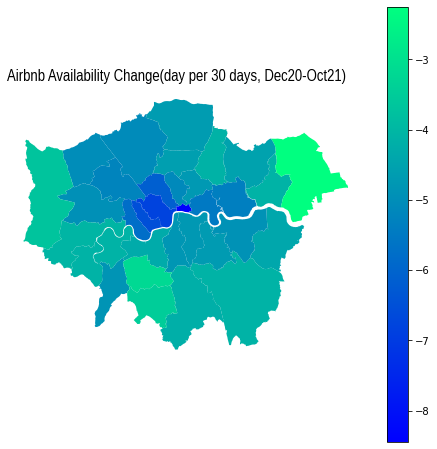

In [33]:
f, ax = plt.subplots(1,1, figsize=(8,8))
ax.axis('off')

target_gdf.plot(column='diff_avail30', ax=ax, legend=True, cmap='winter')
ax.set_title('Airbnb Availability Change(day per 30 days, Dec20-Oct21)', loc='left', size=16, **tfont)

Text(0.0, 1.0, 'Airbnb Median Price Change per Borough(%, Dec20-Oct21)')

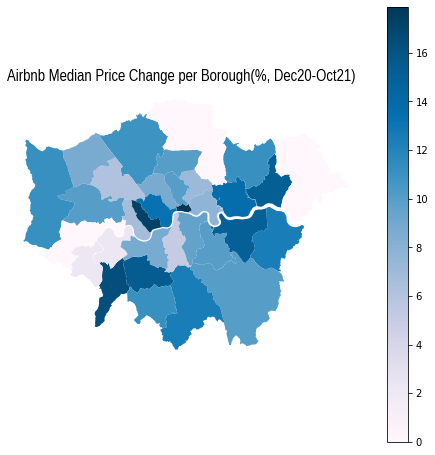

In [34]:
f, ax = plt.subplots(1,1, figsize=(8,8))
ax.axis('off')

target_gdf.plot(column='diff_price', ax=ax, legend=True, cmap='PuBu')
ax.set_title('Airbnb Median Price Change per Borough(%, Dec20-Oct21)', loc='left', size=16, **tfont)

Text(0.0, 1.0, 'Airbnb Density per Dwelling of Borough(%, Oct21)')

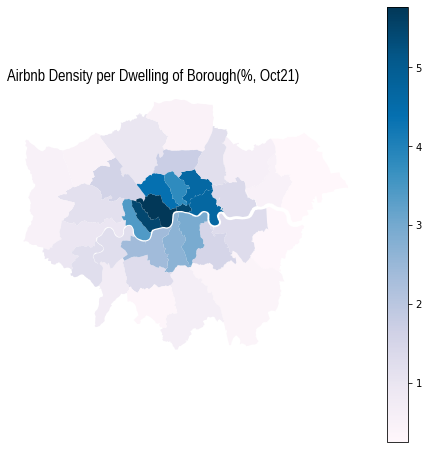

In [32]:
f, ax = plt.subplots(1,1, figsize=(8,8))
ax.axis('off')

target_gdf.plot(column='per_dwell', ax=ax, legend=True, cmap='PuBu')
ax.set_title('Airbnb Density per Dwelling of Borough(%, Oct21)', loc='left', size=16, **tfont)